In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Oppgave 1
## Hvor mange unike IP-adresser?

In [2]:
df = pd.read_csv("O1-Flow.csv", delimiter=";")

SOURCE og DEST inneholder IP-adresse med portnummer. Vi er kun interessert i IP-adresser.
Ekstraherer kun IP-adressene til nye kolonner, og deretter teller unike verdier

In [3]:
src_ips = df['SOURCE'].str.split(":").str[0].rename("SRC_IP")
dst_ips = df['DEST'].str.split(":").str[0].rename("DST_IP")
src_ports = df['SOURCE'].str.split(":").str[1].rename("SRC_PORT")
dst_ports = df['DEST'].str.split(":").str[1].rename("DST_PORT")

src_dst = pd.concat([src_ips, dst_ips], axis = 1)
n_unq_ips = src_dst[["SRC_IP", "DST_IP"]].nunique()
n_unq_ips

SRC_IP     4
DST_IP    54
dtype: int64

# Oppgave 2
## Hva er den total datamengde per IP, per retning?

Før jeg summerer datamengdene, tilføyer jeg de nyopprettede kolonnene fra forrige oppgave i nåværende dataframe.
Dette gir dataframe-en noe redundant info, men nå kan vi gruppere kun med IP

In [50]:
new_df = pd.concat([df, src_ips, src_ports, dst_ips, dst_ports], axis=1)
total_data = new_df.groupby(["SRC_IP", "DST_IP"])['BYTES'].sum()
total_data


SRC_IP        DST_IP       
10.23.35.133  8.8.8.8            5305
10.23.35.60   8.8.8.8             980
10.23.35.61   8.8.8.8           74604
8.8.8.8       10.13.232.147      2546
              10.13.232.190       742
              10.13.232.218      2974
              10.13.232.33        164
              10.13.232.42        255
              10.13.232.45       3007
              10.13.232.50       1405
              10.13.232.57       3270
              10.13.232.83       1662
              10.13.232.88        462
              10.13.232.89        877
              10.13.232.90        371
              10.13.232.91        164
              10.13.232.97         92
              10.23.35.133       8920
              10.23.35.60        2287
              10.23.35.61      220827
              10.41.164.54         92
              10.41.165.1        4903
              10.41.255.1         492
              10.41.255.14        208
              10.41.255.17        174
              10.41.25

## Visualisering av datamengde som Weighted Directed Multi Graph

Takk til kcoskun (https://stackoverflow.com/questions/22785849/drawing-multiple-edges-between-two-nodes-with-networkx) <br>
Denne metoden hadde fungert utmerket i tilfeller hvor det er mindre antall noder...

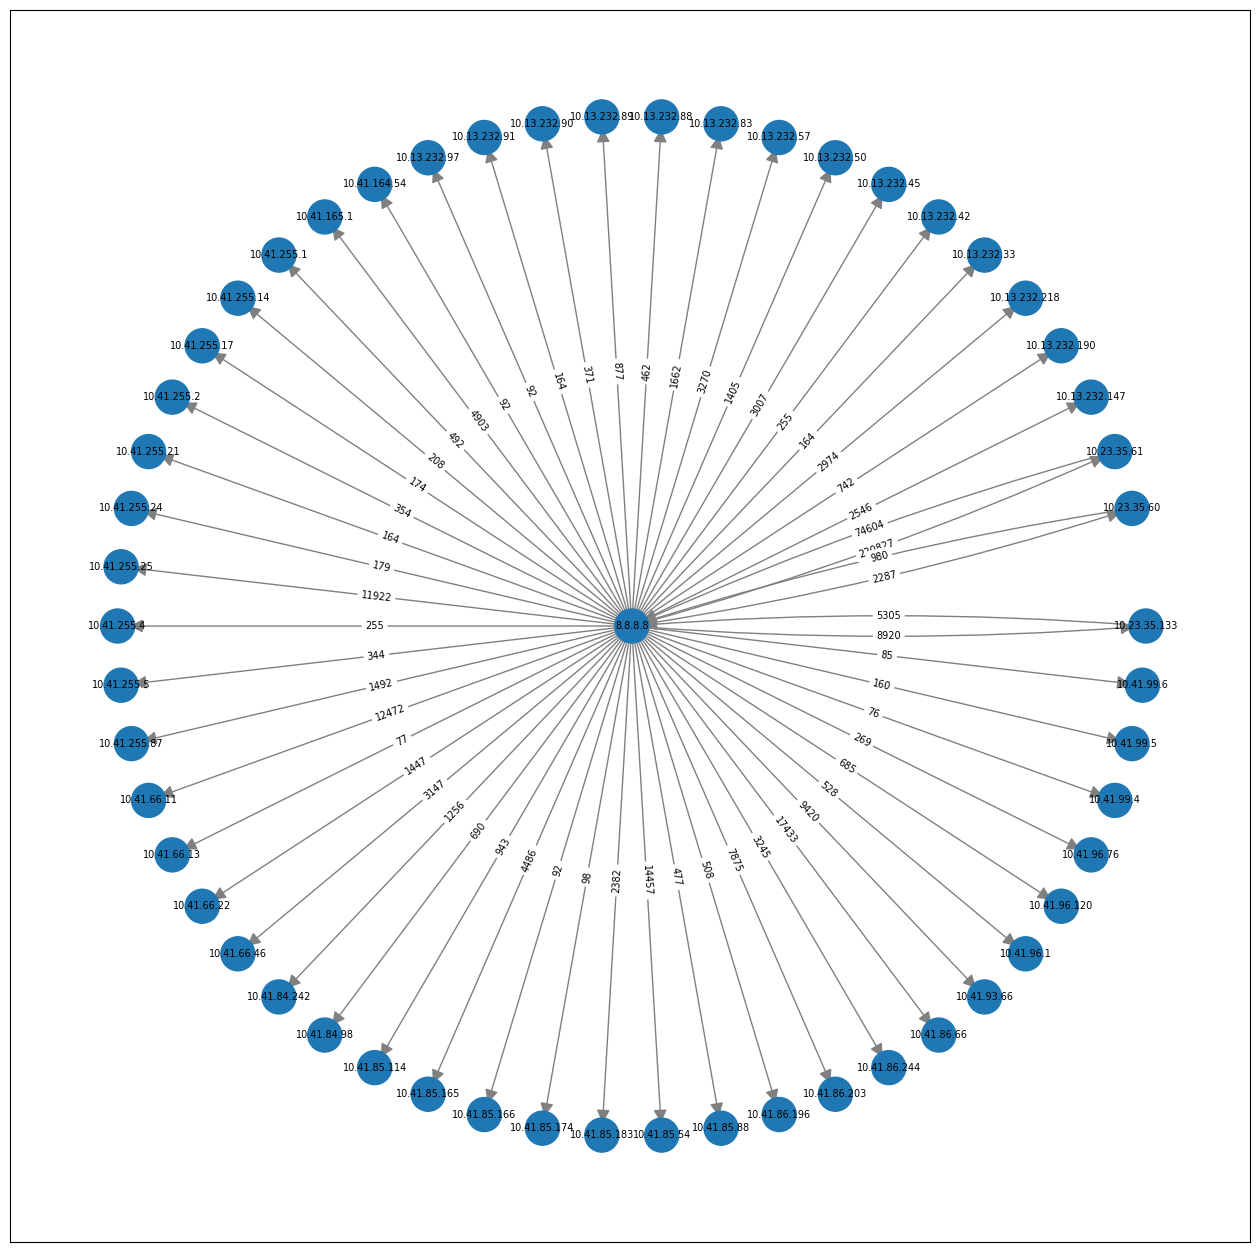

In [142]:
import networkx as nx
import kco_netowrkx as kcnx
#
edges = list(new_df.groupby(["SRC_IP", "DST_IP"])['BYTES'].indices.keys())
srcs = [edge[0] for edge in edges]
dsts = [edge[1] for edge in edges]
weights = total_data.tolist()

g = nx.DiGraph()

for src, dst, w in zip(srcs, dsts, weights):
    g.add_edge(src, dst, weight = w)

pos = nx.circular_layout(g)
pos['8.8.8.8'] = np.array([0, 0])
node_sizes = []
for node in g.nodes():
    if node == '8.8.8.8':
        node_sizes.append(600)
    else:
        node_sizes.append(600)
plt.figure(figsize=(16,16))
nx.draw_networkx_nodes(g, pos, node_size=node_sizes)
nx.draw_networkx_labels(g, pos, font_size=7)

curved_edges = [edge for edge in g.edges() if reversed(edge) in g.edges()]
straight_edges = list(set(g.edges()) - set(curved_edges))
nx.draw_networkx_edges(g, pos, arrowsize=20, edge_color='grey', edgelist=straight_edges)
nx.draw_networkx_edges(g, pos, edgelist=curved_edges, arrowsize=20, edge_color='grey', connectionstyle='arc3, rad=0.04')

edge_weights = nx.get_edge_attributes(g, 'weight')
curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
kcnx.my_draw_networkx_edge_labels(g, pos, font_size=7, edge_labels=curved_edge_labels,rotate=True,rad = 0.04)
nx.draw_networkx_edge_labels(g, pos, font_size=7, edge_labels=straight_edge_labels,rotate=True)
print("")

# Oppgave 3
## Hva er prosentfordelingen av protokollene?
Kakediagrammet viser ikke prosentverdiene under 1%

In [190]:
n_uniq_protocols = new_df['PROTO'].value_counts(normalize=True)
n_uniq_protocols

PROTO
udp     0.979
tcp     0.020
icmp    0.001
Name: proportion, dtype: float64

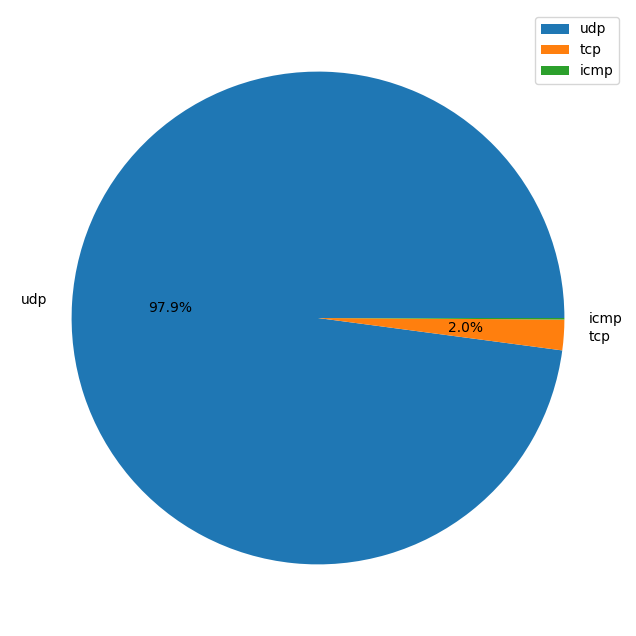

In [194]:
labels = n_uniq_protocols.keys()
sizes = n_uniq_protocols.values
plt.figure(figsize=(8,8))

def autopct_format(pct):
    return f'{pct:.1f}%' if pct > 2 else ''

wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct=autopct_format)

plt.legend()

plt.show()

# Oppgave 4
## Hva er prosentfordelingen blant portene?
### (Alle porter større enn 1024 kan omtales som <i>high ports</i>)

Oppdaget at det er noen av verdiene i de opprinnelige SOURCE og DEST kolonnene ikke er oppført med portnummer. I slike tilfeller vil det oppstå NaN.

In [203]:
all_ports = pd.concat([new_df["SRC_PORT"], new_df["DST_PORT"]]).reset_index(drop=True).rename("PORTS")
all_ports = all_ports[all_ports.notna()].astype(int)
all_ports[all_ports > 1024] = "high port"
counts = all_ports.value_counts(normalize=True).round(3)
counts

/tmp/ipykernel_4125/2351323320.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'high port' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_ports[all_ports > 1024] = "high port"


PORTS
high port    0.499
53           0.498
853          0.002
1024         0.001
Name: proportion, dtype: float64

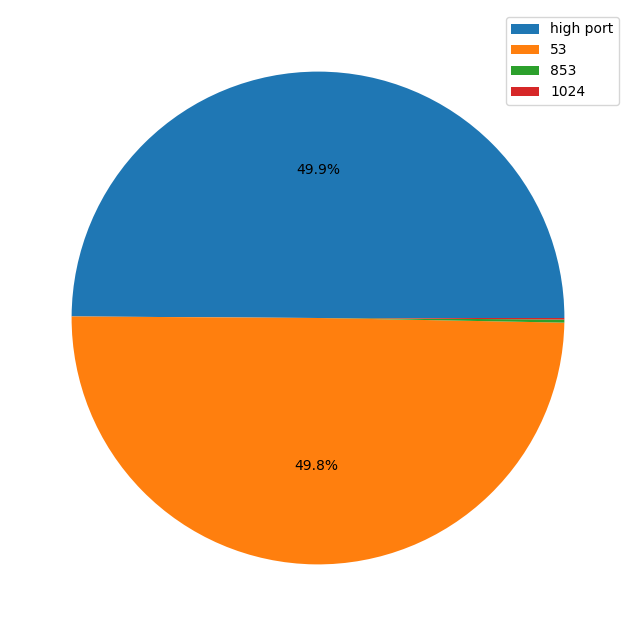

In [204]:
labels = counts.keys()
sizes = counts.values
plt.figure(figsize=(8,8))
wedges, texts, autotexts = plt.pie(sizes, autopct=autopct_format)
plt.legend(wedges, labels)
plt.show()